# Training the Ultra-Fast Lane Detection network

This Jupyter Notebook trains the Ultra-Fast Lane Detection network using LLAMAS data.

You need the LLAMAS dataset (adjust `BASE_PATH` below) and the LLAMAS python library. Just clone it to the same directory as this notebook:
```
git clone https://github.com/karstenBehrendt/unsupervised_llamas.git
```

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time

2023-07-25 17:59:34.543499: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-25 17:59:34.605961: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-25 17:59:34.608519: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-25 17:59:35.663259: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from models.ultrafast import UltraFastNet

NUM_LANES = 2
INPUT_SIZE = (288, 800)
CLS_SHAPE = (20, 100, NUM_LANES)

INPUT_SHAPE = (*INPUT_SIZE, 3)
OUTPUT_SHAPE = CLS_SHAPE

DTYPE = tf.float32

ufm = UltraFastNet(num_lanes=NUM_LANES, size=INPUT_SIZE, cls_dim=CLS_SHAPE, use_aux=False)

In [3]:
import losses

In [4]:
ufm.compile(optimizer='adam', loss=losses.ultrafast_loss)
ufm.summary()

Model: "ultra_fast_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 backbone (Backbone)         multiple                  11190912  
                                                                 
 cls (Sequential)            (None, 4000)              11884448  
                                                                 
 pool (Conv2D)               multiple                  4104      
                                                                 
 softmax (Softmax)           multiple                  0         
                                                                 
Total params: 23079464 (88.04 MB)
Trainable params: 23069864 (88.00 MB)
Non-trainable params: 9600 (37.50 KB)
_________________________________________________________________


In [5]:
TAKE_LLAMAS_MAX = 1000
TAKE_CULANE_MAX = 0
TAKE_MIWULA_MAX = 0 # all of them

# Ratio of validation data vs training data
VALID_RATIO = 0.3

BATCH_SIZE = 8 # tune to available GPU memory
PREFETCH_SIZE = 200 # tune to available memory

#USE_DATA_AUGMENTATION = True

EPOCHS = 2 # training epochs

In [6]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.show()

TODO: This LLAMAS code was just copied from a previous image segmentation experiment, needs to be adopted to Ultra Fast network. But kinda works anyway

In [7]:
import json
import os
from unsupervised_llamas.label_scripts.spline_creator import get_horizontal_values_for_four_lanes

BASE_PATH = '../../data/labels/'

LLAMAS_SHAPE = (717, 1276, 3)
#MASK_SHAPE = (712, 1272, 3)

IMAGE_SHAPE = INPUT_SHAPE
MASK_SHAPE = OUTPUT_SHAPE

PARALLEL_JOBS = 4# tf.data.experimental.AUTOTUNE


def resize_img(img, shape):
    w = img.shape[1]
    h = img.shape[0]
    
    ratio = shape[1] / shape[0]
    
    tgt = img[h-int(w/ratio):h,0:w]
    tgt = cv2.resize(tgt, (shape[1], shape[0]))
    return tgt

def draw_spline(img, points, color):
    n = np.array(points)
    idx = np.arange(0, len(n)).reshape(-1,1)
    idx = idx[n >= 0]
    n = n[n >= 0]
    n = n.reshape(-1,1)
    pts = np.hstack((n, idx))
    
    cv2.polylines(img, np.int32([pts]), isClosed=False, color=color, thickness=10, lineType=cv2.LINE_8)
    
    del n
    del idx
    del pts

def generate_mask(file):
    file = file.numpy().decode("utf-8")
    mask = np.zeros(LLAMAS_SHAPE, dtype='uint8')
    
    lines = get_horizontal_values_for_four_lanes(file)
    l0 = lines[1]
    r0 = lines[2]
    
    draw_spline(mask, l0, (0,255,0))
    draw_spline(mask, r0, (255,0,0))
    
    mask = resize_img(mask, MASK_SHAPE)
    return mask[:,:,0:2]

def read_image(file):
    file = file.numpy().decode("utf-8")
    with open(file, 'r') as fp:
        meta = json.load(fp)
        
    image_path = os.path.dirname(file)
    image_path = image_path.replace('/labels/', '/color_images/')
    img_name = meta['image_name'] + '_color_rect.png'
    fname = os.path.join(image_path, img_name)
    
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return resize_img(img, IMAGE_SHAPE)

def process_json(json):
    img = tf.py_function(read_image, [json], Tout=DTYPE)
    mask = tf.py_function(generate_mask, [json], Tout=DTYPE)
    
    img = tf.reshape(img, shape=IMAGE_SHAPE)
    mask = tf.reshape(mask, shape=MASK_SHAPE)
    return img, mask

SHUFFLE_SIZE = 100000

llamas_train_ds = tf.data.Dataset.list_files(os.path.join(BASE_PATH, 'train', '*/*.json'))
llamas_train_ds = llamas_train_ds.shuffle(SHUFFLE_SIZE)

llamas_train_ds = llamas_train_ds.take(TAKE_LLAMAS_MAX)
LLAMAS_TRAIN_LEN = len(list(llamas_train_ds))
print('LLAMAS training images: %d' % LLAMAS_TRAIN_LEN)

llamas_train_ds = llamas_train_ds.map(process_json, num_parallel_calls=PARALLEL_JOBS)

llamas_valid_ds = tf.data.Dataset.list_files(os.path.join(BASE_PATH, 'valid', '*/*.json'))
llamas_valid_ds = llamas_valid_ds.shuffle(SHUFFLE_SIZE)

llamas_valid_ds = llamas_valid_ds.take(TAKE_LLAMAS_MAX)
LLAMAS_VALID_LEN = len(list(llamas_valid_ds))
print('LLAMAS validation images: %d' % LLAMAS_VALID_LEN)

llamas_valid_ds = llamas_valid_ds.map(process_json, num_parallel_calls=PARALLEL_JOBS)


LLAMAS training images: 1000
LLAMAS validation images: 1000


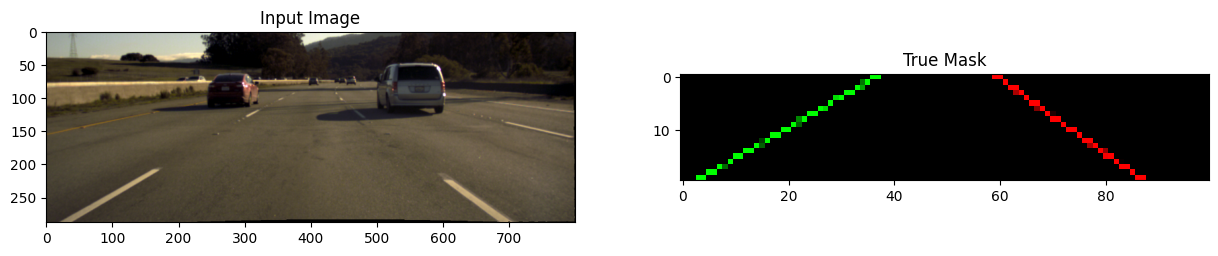

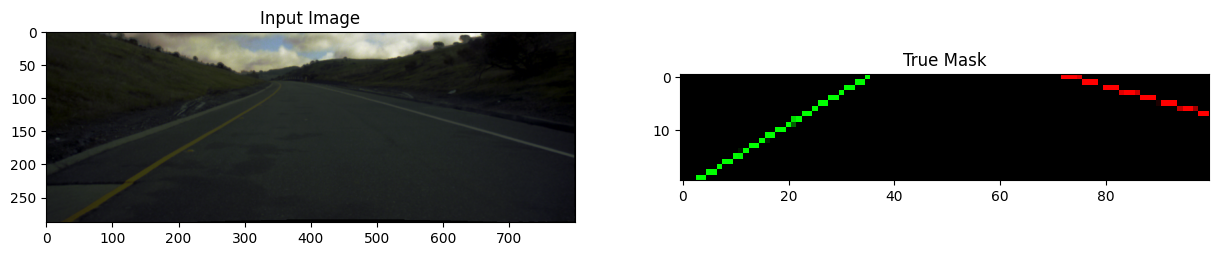

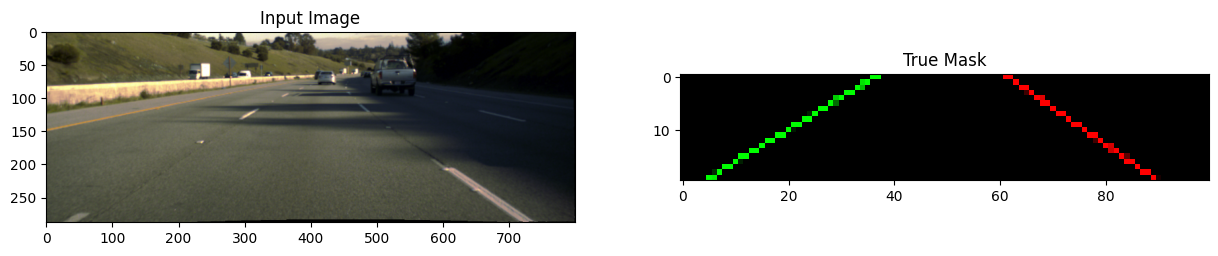

In [8]:
for img, mask in llamas_valid_ds.take(3):
    m = tf.zeros((20,100,1), dtype=DTYPE)
    m = tf.concat([mask, m], -1)
    display([img, m])

In [9]:
import glob

json_glob = glob.glob(os.path.join(BASE_PATH, 'train', '*/*.json'))

In [10]:
json_file = json_glob[0]
lines = get_horizontal_values_for_four_lanes(json_file)

In [11]:
CLS_SHAPE

(20, 100, 2)

In [12]:
train_ds = llamas_train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(PREFETCH_SIZE)

valid_ds = llamas_valid_ds.take(int(TAKE_LLAMAS_MAX * 0.3)).batch(BATCH_SIZE)
valid_ds = valid_ds.prefetch(PREFETCH_SIZE)

ufm.fit(train_ds, validation_data=valid_ds, epochs=EPOCHS, verbose=1)

Epoch 1/2
125/125 [==============================] - 635s 5s/step - loss: 133170.0625 - val_loss: 531099.1250
Epoch 2/2
125/125 [==============================] - 619s 5s/step - loss: 73988.2812 - val_loss: 102055.3672


1/1 [==============================] - 1s 618ms/step
0.6980102062225342


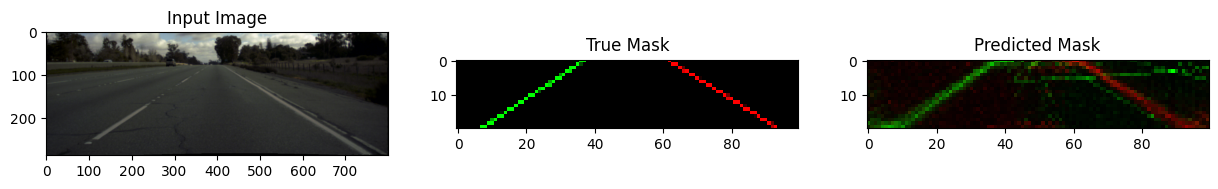

1/1 [==============================] - 0s 173ms/step
0.22101187705993652


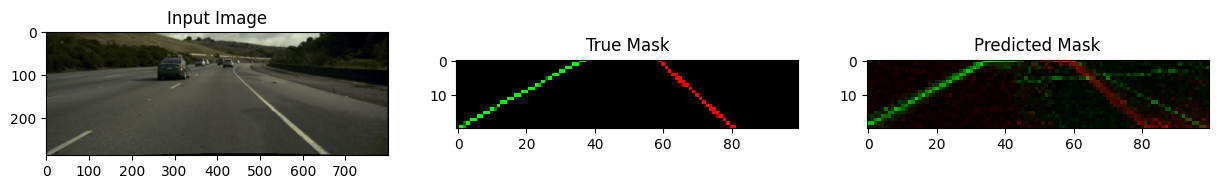

1/1 [==============================] - 0s 182ms/step
0.2277994155883789


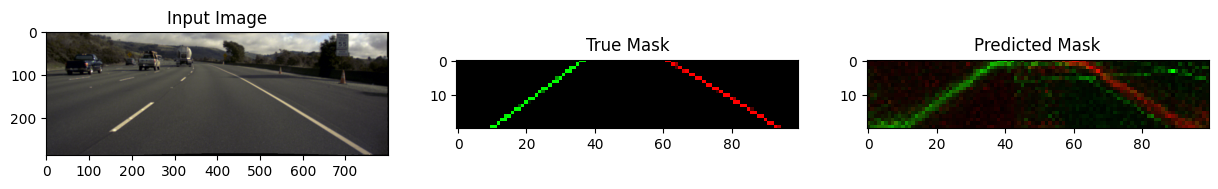

1/1 [==============================] - 0s 173ms/step
0.23087215423583984


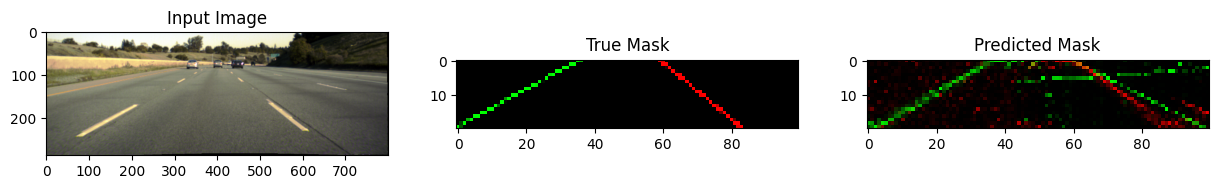

1/1 [==============================] - 0s 178ms/step
0.21906805038452148


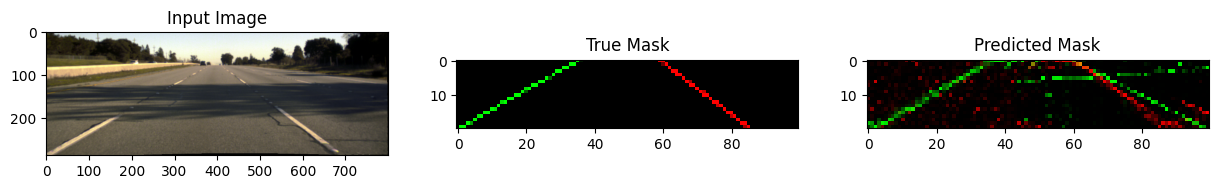

In [13]:
for img, mask in llamas_valid_ds.take(5):
    s = time.time()
    pred = ufm.predict(tf.expand_dims(img, axis=0))
    e = time.time()
    print(e-s)
    pred = pred[0]
    m = tf.zeros((20,100,1), dtype=DTYPE)
    m = tf.concat([pred, m], -1)
    
    m2 = tf.zeros((20,100,1), dtype=DTYPE)
    m2 = tf.concat([mask, m2], -1)
    
    display([img, m2, m])

In [14]:
ufm.save('ultrafast.tf', save_format='tf')

INFO:tensorflow:Assets written to: ultrafast.tf/assets


INFO:tensorflow:Assets written to: ultrafast.tf/assets


## Converting to TF Lite for use with Google EdgeTPU

This code converts and quantizes the network for use with a coral stick. The resulting `ultrafast_quant.tflite` needs to be compiled with the EdgeTPU compiler.

In [15]:
def representative_data_gen():
    for img, mask in llamas_valid_ds:
        yield [tf.expand_dims(img, axis=0)]

converter = tf.lite.TFLiteConverter.from_keras_model(ufm)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.int8]
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# These set the input and output tensors to uint8 (added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
# And this sets the representative dataset so we can quantize the activations
converter.representative_dataset = representative_data_gen
tflite_model = converter.convert()

with open('ultrafast_quant.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp_z7zuv44/assets


INFO:tensorflow:Assets written to: /tmp/tmp_z7zuv44/assets
/home/admin/python_envs/ufld/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2023-07-25 18:22:04.050818: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-07-25 18:22:04.050887: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-07-25 18:22:04.052793: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_z7zuv44
2023-07-25 18:22:04.072867: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-07-25 18:22:04.072913: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmp_z7zuv44
2023-07-25 18:22:04.126008: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization p

### Test the TF Lite model

In [16]:
interpreter = tf.lite.Interpreter('ultrafast_quant.tflite')
interpreter.allocate_tensors()

def set_input(interpreter, tensor):
    input_details = interpreter.get_input_details()[0]
    print(input_details)
    tensor_index = input_details['index']
    input_tensor = interpreter.tensor(tensor_index)()[0]
    
    scale, zero_point = input_details['quantization']
    
    input_tensor[:, :] = tensor

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([  1, 288, 800,   3], dtype=int32), 'shape_signature': array([ -1, 288, 800,   3], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (1.0, 0), 'quantization_parameters': {'scales': array([1.], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'StatefulPartitionedCall:0', 'index': 88, 'shape': array([  1,  20, 100,   2], dtype=int32), 'shape_signature': array([ -1,  20, 100,   2], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.00390625, 0), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


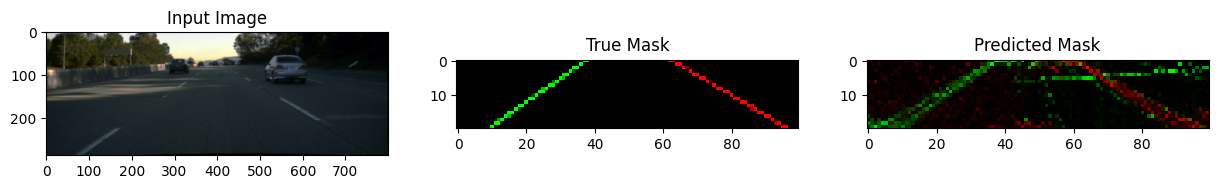

In [17]:
for img, mask in llamas_valid_ds.take(1):
    set_input(interpreter, img)
    interpreter.invoke()
    
    output_details = interpreter.get_output_details()[0]
    print(output_details)
    output = interpreter.get_tensor(output_details['index'])
    # Outputs from the TFLite model are uint8, so we dequantize the results:
    scale, zero_point = output_details['quantization']
    #output = scale * (output - zero_point)
    
    m = tf.zeros((20,100,1), dtype=DTYPE)
    m = tf.concat([output[0], m], -1)
    
    m2 = tf.zeros((20,100,1), dtype=DTYPE)
    m2 = tf.concat([mask, m2], -1)
    
    display([img, m2, m])
    
    #print(output)

### Test loading a saved TF model

In [18]:
ufml = tf.keras.models.load_model('ultrafast.tf', custom_objects={'loss': losses.ultrafast_loss}, compile=False)

In [19]:
ufm.compile(optimizer='adam', loss=losses.ultrafast_loss)
ufm.summary()

Model: "ultra_fast_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 backbone (Backbone)         multiple                  11190912  
                                                                 
 cls (Sequential)            (None, 4000)              11884448  
                                                                 
 pool (Conv2D)               multiple                  4104      
                                                                 
 softmax (Softmax)           multiple                  0         
                                                                 
Total params: 23079464 (88.04 MB)
Trainable params: 23069864 (88.00 MB)
Non-trainable params: 9600 (37.50 KB)
_________________________________________________________________


In [20]:
ufml.summary()

Model: "ultra_fast_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 backbone (Backbone)         multiple                  11190912  
                                                                 
 cls (Sequential)            (None, 4000)              11884448  
                                                                 
 pool (Conv2D)               multiple                  4104      
                                                                 
 softmax (Softmax)           multiple                  0         
                                                                 
Total params: 23079464 (88.04 MB)
Trainable params: 23069864 (88.00 MB)
Non-trainable params: 9600 (37.50 KB)
_________________________________________________________________
